# Preliminaries

At some point, the memory required to analyse metagenomic data <!--LPC: link to some resource on metagenomic data.--> becomes more than an off-the-shelf laptop can manage. The [Global Microbial Gene Catalog](http://gmgc.embl.de/download.cgi) contains >300 million sequences. How can we use such resources without requiring very large computational resources? For example, when mapping a dataset of short-reads using [NGLess](http://ngless.embl.de/).

A natural answer is to split-up the database and work on each segment, rather than all at once. There are multiple ways to do this, the [simplest of which](http://ngless.embl.de/Mapping.html#low-memory-mode) is to simply break up the database in whatever order it is in, without regard for the sequences.

One potentially better solution is to split-up the database so there are the fewest possible sequences in different chunks that share $k$-mers (a $k$-mer being a subsequence of size $k$). In the ideal case, no chunks of the database share a $k$-mer.

We can model the structure of the database as a graph: each node on the graph corresponds a sequence and if two sequences share a $k$-mer, they are considered connected (i.e. there's an edge between them). The size of the largest connected component in the graph determines the minimal size of the chunk in the ideal "no k-mer sharing" situation. This naturally depends on the size of $k$ (if $k$ is very small, everything is connected, if it is very large, almost nothing is). What should $k$ be?

Understanding how the distribution of the connected components (https://en.wikipedia.org/wiki/Component_(graph_theory)) changes with $k$ will require modelling what the graph of $k$-mers looks like.  The model discussed here makes many simplifying assumptions to form a heuristic, preliminary analysis. In particular, we use an [Erdös-Renyi graph](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model). That is, each node is equally likely to be connected to one another. Thus, according to our equation above, we imagine flipping a biased coin for each pair of nodes to determine whether they are connected or not.

What is this edge probability? First, given a sequence of size $N$, there are $N - k + 1$, $k$-mers (https://en.wikipedia.org/wiki/K-mer). Furthermore, given the genetic alphabet of $ACTG$, there are $4^k$ possible $k$-mers in total. For example, the sequence $ACCG$ has $4 - 2 + 1 = 3$, $2$-mers $AC$, $CC$ and $CG$. Whereas, we have $A$, $C$, $C$ and $G$, or $4^1 = 4$, $1$-mers of the sequence $ACCG$. Now, given that a $k$-mer and its reverse compliment are considered equivalent, we actually have $4^{k}/2$ possible sequences of size $k$. Therefore, we approximate the probability two sequences share a $k$-mer by $$p = \frac{2(N - k + 1)^2}{4^k}.$$ There are $(N - k + 1)^2$ possible $k$-mer pairings between our two sequences out of a possible $4^k$, $k$-mers. Given that $N = 1000$ is a reasonable average length for some sequence in a database, our approximation becomes $$p = \frac{2(1001-k)^2}{4^k}.$$

The Erdös-Renyi random graph model has interesting properties. We define $n$ as the number of nodes in the graph (i.e. the number of sequences in the database) and $p$ as the probability two $k$-mers are connected. The mathematical results that concern us - proved by Erdös and Renyi (https://www.renyi.hu/~p_erdos/1960-10.pdf) in 1960 - are (https://youtu.be/OdMRFvK7-9I?t=926):
1. If $np<1$ , then the largest connected component is of order $\log n$ (with high probability).
2. If $np>1$, then there exists a unique *giant* component (https://en.wikipedia.org/wiki/Giant_component) of size $\rho n$ where $\rho$ is the solution in $(0,1)$ to $\exp(-npx) = 1-x$ (a fraction of the total number of nodes in the graph). The rest of the components are of order $\log n$. 

Using our formula for the probability of two sequences sharing a $k$-mer, we can now plot the size of the largest connected component against $k$ for varying numbers of sequences:

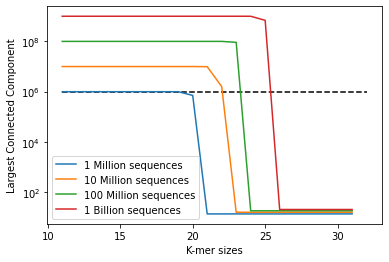

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo


def kmer_probability(k): 
    '''The probability of two k-mers being the same assuming an average length of 1000
    '''
    
    if k<11:
        raise ValueError("input k must be greater than 11 for probability to be less than 1")
        
    if k - int(k) != 0:
        raise ValueError("Input must be an integer (not type, just k - int_part(k) == 0)")
        
    return (2*((1001-k)**2))/(4**k)

def np_calculator(n, k):
    
    if k - int(k) != 0 or n - int(n) != 0:
        raise ValueError("Inputs must be integers (not type, just a - int_part(a) == 0)")
    
    return n*kmer_probability(k)

def solve_for_lambda(x, l):
    
    return np.exp(-l*x) + x - 1



def plot_kmers_against_largestCCs(kmer_range):
    
    results_1million = []
    
    results_10million = []
    
    results_100million = []
    
    results_1billion = []
    
    kmer_sizes = np.array([k for k in range(11,11+kmer_range)])
    
    nps_1million = [np_calculator(10**6, k) for k in kmer_sizes]
    nps_10million = [np_calculator(10**7, k) for k in kmer_sizes]
    nps_100million = [np_calculator(10**8, k) for k in kmer_sizes]
    nps_1billion = [np_calculator(10**9, k) for k in kmer_sizes]
    
    
    
    #loop through kmer_sizes and find largest connected component
    for i in range(kmer_range):
        
        if nps_1million[i] == 1 or nps_10million[i] == 1 or nps_100million[i] == 1 or nps_1billion[i] == 1:
            raise ValueError("There's an np == 1 value")
        
        if nps_1million[i] > 1:
            
            #use newton's method to find size of largest component as a fraction of total number of nodes
            results_1million.append(10**6 * (spo.newton(solve_for_lambda,1.5,args=[nps_1million[i]])))
            
            
        else:
            results_1million.append(np.log(10**6))
        
        if nps_10million[i] > 1:

            results_10million.append(10**7 * (spo.newton(solve_for_lambda,1.5,args=[nps_10million[i]])))
            
        else:
            results_10million.append(np.log(10**7))
            
        if nps_100million[i] > 1:
            
            results_100million.append(10**8 * (spo.newton(solve_for_lambda,1.5,args=[nps_100million[i]])))
            
        else:
            results_100million.append(np.log(10**8))
            
        if nps_1billion[i] > 1:
            
            results_1billion.append(10**9 * (spo.newton(solve_for_lambda,1.5,args=[nps_1billion[i]])))
            
        else:
            results_1billion.append(np.log(10**9))
                
    
    return kmer_sizes, results_1million, results_10million, results_100million, results_1billion

kmer_range = 21

results = plot_kmers_against_largestCCs(kmer_range)

plt.figure()
plt.plot(results[0], results[1], label='1 Million sequences')
plt.plot(results[0], results[2], label='10 Million sequences')
plt.plot(results[0], results[3], label='100 Million sequences')
plt.plot(results[0], results[4], label='1 Billion sequences')
plt.hlines(10**6, 11, 11+kmer_range, linestyles='dashed')
plt.xlabel('K-mer sizes')
plt.ylabel('Largest Connected Component')
plt.yscale('log')
plt.xticks(np.arange(10,10+kmer_range, 5))
plt.legend()

# Comments on Results

The dotted line represents the situation where the largest connected component is $1$ million nodes in size. As we can see, already with a file size of $1$ million sequences, we need $k > 20$ for the largest component to drop below the dotted line. Furthermore, once the critical threshold is passed, the size of this component is expected to drop quickly.

In future, we would like to account for different sequence lengths within the same database, perhaps using a Gaussian of some kind. Furthermore, our probability formula requires $k \geq 11$ so $p \leq 1$. The current formula is considered to be a reasonable approximation to a more precise equation. The nodes of Erdös-Renyi random graphs are equally likely to be connected to each other, which is another aspect of the model we would like to refine.

If you would like to run the notebook on your own machine, use the following binder link: https://mybinder.org/v2/gh/t-l-g/ksplitwriteup/HEAD?filepath=K-SplitNotebook.ipynb.